## **Welcome to the LabTA Scheduler**

In [31]:
from pulp import *
import max_weight_cap
from schedule import Schedule
import stats
import input_creator
import pandas as pd
import numpy as np

In [32]:
def color_schedule(val):
    if int(val) == -3.0:
        background_color = 'green'
    elif int(val) == -2.0:
        background_color = 'yellow'
    elif int(val) == -1.0:
        background_color = 'red'
    else:
        background_color = ''
    return 'background-color: %s' % background_color

In [33]:
def color_wrong_type(s):
    '''
    highlight the wrong types dark orange
    '''
    is_wrong = s == True
    return ['background-color: darkorange' if v else '' for v in is_wrong]

## **Default Schedule Inputs**

These inputs are the defaults based on the Fall 2019 LabTA Schedule. Please edit the title of the csv file to being your own csv file. Change the slotdict keys and values as needed for changes in the slots and number of shifts per slot in the schedule.

In [34]:
#Default csv file
csv_file = 'LabTA_test2 - Sheet1.csv'

#dict of target number of students in each slot
slotdict = {"Mo_19" : 8, "Mo_21" : 6,"Tu_19" : 5, "Tu_21" : 5,"We_19" : 5, "We_21" : 5,"Th_19" : 5, "Th_21" : 4,"Fr_19" : 4, "Fr_21" : 4,"Sa_15" : 5, "Sa_16" : 6,"Sa_17" : 5,"Su_17" : 4,"Su_18" : 3,"Su_19" : 6,"Su_20" : 4, "Su_21" : 6}

In [50]:
duration = 2 #length of slots (in hours)

#default column values
gap = 3
cap = 2
skill = 4
exp = 3

#list of slots that need more skilled TA's
stress_slots = []

#numeric value indicating how many TAs the scheduler can hire above the targeted value for any given slot
target_delta = 0

#number of shifts the scheduler can assign in addition to the slotdict shift numbers
flex_shifts = 0

#sets minimum number of experienced TA's per slot
MIN_EXP = 0

#sets minimum number of skilled TA's per stress slot
MIN_SKILL = 0

#gets number of slots
NUM_SLOTS = 0
for slot in slotdict:
    NUM_SLOTS += slotdict[slot]
    
#Default weights
weight_dict = {}
weight_dict['slot_type'] = 4
weight_dict['no_1'] = 3
weight_dict['guarantee_shift'] = 5
weight_dict['avail'] = 7
weight_dict['shift_cap'] = 5
weight_dict['equality'] = 3

In [51]:
def results(weight_dict, input_csv, slotdict):
    df = input_creator.get_df(input_csv)
    
    students = list(df['name'])
    #check if gap, cap, exp, skill cols are in df
    if 'gap' not in list(df.columns):
        #add gap col
        gap_list = input_creator.make_col(students, gap)
        df['gap'] = gap_list
    if 'cap' not in list(df.columns):
        #add cap col
        shift_cap_list = input_creator.make_col(students, cap)
        df['cap'] = shift_cap_list #add cap column to df
    if 'experience' not in list(df.columns):
        #add experience col
        exp_list = input_creator.make_col(students, exp)
        df['experience'] = exp_list #add experience column to df
    if 'skill' not in list(df.columns):
        skill_list = input_creator.make_col(students, skill)
        df['skill'] = skill_list
    
    #dict of slots to check as keys, and overlapping slots as values (student won't be placed in overlap)
    slots = input_creator.get_slots(df)
    #dict of slots and their prev slots
    PREV_SLOT = input_creator.get_prev_slots(df, duration)

    #get experience dict and fake temp skill dict for testing
    exp_dict = {}
    skill_dict = {}
    students = list(df['name'])
    for index in range(len(df['name'])):
        exp_dict[str(df.at[index, 'name'])] = int(df.at[index, 'experience'])
        skill_dict[str(df.at[index, 'name'])] = int(df.at[index, 'skill'])
    
    #create graph nodes and weight edges
    graph_data = max_weight_cap.create_graph(df, weight_dict, slotdict, PREV_SLOT, NUM_SLOTS, duration)
    student_nodes = graph_data[0]
    slot_nodes = graph_data[1]
    wt = graph_data[2]
    
    #solve the problem and get the ordered schedule
    p = max_weight_cap.solve_wbm(student_nodes, slot_nodes, wt, df, slotdict, MIN_EXP, MIN_SKILL, stress_slots, target_delta, flex_shifts, duration)
    unordered_sched_dict = max_weight_cap.get_solution(p)
    max_weight_sched = max_weight_cap.order_sched(df, unordered_sched_dict, slotdict)

    #print df, exp and happiness stats
    max_weight_cap.schedule_to_df(df, max_weight_sched)    

    post_hap = stats.sched_happiness(df, max_weight_sched, PREV_SLOT)
    df['wrong type'] = post_hap[8]
    cols = ['name']
    cols2 = list(slotdict.keys())
    cols.extend(cols2)
    cols3 = ['happiness', 'wrong type', 'slot_type', 'availability', 'cap', 'experience', 'skill', 'hours']
    cols.extend(cols3)
    df = df[cols]
    styled_df = df.style.\
        applymap(color_schedule, subset = pd.IndexSlice[:, max_weight_sched.schedule.keys()]).\
        apply(color_wrong_type, subset=['wrong type'])
    
    display(styled_df)
    
    print("Max Weight schedule stats:")
    stats.exp_stats(exp_dict, max_weight_sched)
    stats.skill_stats(skill_dict, max_weight_sched)
    
    #Evaluate happiness stats of schedule
    print('Average Happiness: ', post_hap[0])
    print()
    print('Availability to happiness correlation: ', post_hap[1])
    print()
    print('Variance of happiness: ', post_hap[2])
    print()
    print('Min happy outlier students: ', post_hap[3])
    print()
    print('Max happy outlier students: ', post_hap[4])
    print()
    print('Students who got 1\'s: ', post_hap[5])
    print()
    print('Students without shifts: ', post_hap[6])
    print()
    print('Students who got wrong slot type: ', post_hap[7])
    print()
    
    return(max_weight_sched)
    

Status: Optimal


,name,Mo_19,Mo_21,Tu_19,Tu_21,We_19,We_21,Th_19,Th_21,Fr_19,Fr_21,Sa_15,Sa_16,Sa_17,Su_17,Su_18,Su_19,Su_20,Su_21,happiness,wrong type,slot_type,availability,cap,experience,skill,hours
0,Ben Schiffer,3,-3,1,1,0,0,2,2,0,0,1,1,1,3,3,0,3,-3,100,True,4,27,2,3,4,4
1,Urvashi Uberoy,-3,1,-3,1,3,2,3,2,0,0,0,0,0,1,1,0,0,0,100,False,2,20,2,3,4,4
2,Tajreen Ahmed,-3,1,3,1,3,1,-3,1,0,0,0,0,0,0,0,0,0,0,100,False,2,16,2,3,4,4
3,Aniela Macek,3,3,0,0,0,1,2,2,1,1,0,0,0,0,0,-3,3,-3,100,False,0,22,2,3,4,4
4,Kyle Johnson,-3,1,1,1,-3,1,1,1,2,1,0,0,0,2,2,1,0,0,100,False,2,20,2,3,4,4
5,Somya Arora,1,1,0,1,3,3,0,3,-3,-3,2,0,0,0,0,1,0,0,100,True,2,21,2,3,4,4
6,Khyati Agrawal,-3,1,2,1,-3,2,3,2,1,0,1,1,1,1,1,1,1,1,100,False,2,26,2,3,4,4
7,Donovan Coronado,0,0,0,0,1,1,1,1,-3,1,1,-3,1,2,2,1,0,0,100,False,0,18,2,3,4,4
8,Annie Zhou,-3,1,0,1,3,2,0,0,-3,2,2,0,0,1,0,1,1,1,100,False,2,21,2,3,4,4
9,Sandun Bambarandage,3,-3,0,0,2,2,0,0,2,2,1,1,2,3,-3,1,1,1,100,False,0,27,2,3,4,4


Max Weight schedule stats:


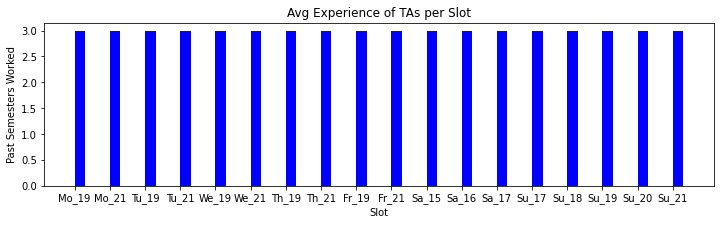

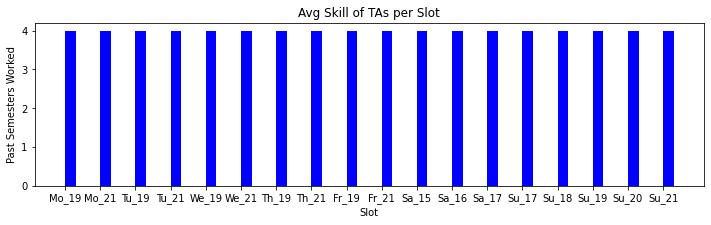

Average Happiness:  97.40740740740742

Availability to happiness correlation:  0.12886477148735784

Variance of happiness:  0.0037317620650954026

Min happy outlier students:  []

Max happy outlier students:  []

Students who got 1's:  []

Students without shifts:  []

Students who got wrong slot type:  ['Ben Schiffer', 'Somya Arora', 'Nathan Alam', 'Avi Bendory', 'Lily Zhang', 'Michelle Woo', 'Nala Sharadjaya', 'Catherine Yu']



In [52]:
max_weight_sched = results(weight_dict, csv_file, slotdict)

## **Print Schedule:**

In [23]:
max_weight_sched.print_sched()

Mo_19 : 
['Aditya Kohli', 'Akash Pattnaik', 'Annie Zhou', 'Caroline di Vittorio', 'Khyati Agrawal', 'Kyle Johnson', 'Nala Sharadjaya', 'Urvashi Uberoy']
Mo_21 : 
['Ben Schiffer', 'HJ Suh', 'Michelle Woo', 'Sandun Bambarandage', 'Yashodhar Govil', 'Ze Xin Koh']
Tu_19 : 
['Ally Dalman', 'Bobby Morck', 'Justin Chang', 'Sahan Paliskara', 'Uri Schwartz']
Tu_21 : 
['Alan Ding', 'Bobby Morck', 'Justin Chang', 'Sahan Paliskara', 'Shaurya Garg']
We_19 : 
['Arjun Devraj', 'Charlie Smith', 'Kyle Johnson', 'Tajreen Ahmed', 'Urvashi Uberoy']
We_21 : 
['Ariel Rakovitsky', 'Caroline di Vittorio', 'Charlie Smith', 'Jason Xu', 'Kawin Tiyawattanaroj']
Th_19 : 
['Arjun Devraj', 'Kawin Tiyawattanaroj', 'Khyati Agrawal', 'Niranjan Shankar', 'Tajreen Ahmed']
Th_21 : 
['Avi Bendory', 'Caio Costa', 'Catherine Yu', 'Niranjan Shankar']
Fr_19 : 
['Annie Zhou', 'Connie Miao', 'Donovan Coronado', 'Somya Arora']
Fr_21 : 
['Lily Zhang', 'Nathan Alam', 'Ryan Golant', 'Somya Arora']
Sa_15 : 
['Anu Vellore', 'Caio Cost

## **Advanced Schedule Inputs**

These inputs are for customizing the schedule based on more detailed preferences

In [28]:
#custom weights
weight_dict_custom = {}
weight_dict_custom['slot_type'] = 5
weight_dict_custom['no_1'] = 7
weight_dict_custom['guarantee_shift'] = 6
weight_dict_custom['avail'] = 6
weight_dict_custom['shift_cap'] = 3
weight_dict_custom['equality'] = 3

In [29]:
#list of slots that need more skilled TA's
stress_slots = ["Mo_19", "Mo_21", "Su_20", "Su_21"]

#sets minimum number of skilled TA's per stress slot
MIN_SKILL = 2

#numeric value indicating how many TAs the scheduler can hire above the targeted value for any given slot
target_delta = 2

#number of shifts the scheduler can assign in addition to the slotdict shift numbers
flex_shifts = 4

#sets minimum number of experienced TA's per slot
MIN_EXP = 3


Status: Optimal


,name,Mo_19,Mo_21,Tu_19,Tu_21,We_19,We_21,Th_19,Th_21,Fr_19,Fr_21,Sa_15,Sa_16,Sa_17,Su_17,Su_18,Su_19,Su_20,Su_21,happiness,wrong type,slot_type,availability,cap,experience,skill,hours
0,Ben Schiffer,3,-3,1,1,0,0,2,2,0,0,1,1,1,3,3,0,-3,3,100,True,4,27,2,3,4,4
1,Urvashi Uberoy,-3,1,3,1,3,2,-3,2,0,0,0,0,0,1,1,0,0,0,100,False,2,20,2,3,4,4
2,Tajreen Ahmed,-3,1,3,1,-3,1,3,1,0,0,0,0,0,0,0,0,0,0,100,False,2,16,2,3,4,4
3,Aniela Macek,3,3,0,0,0,1,2,2,1,1,0,0,0,0,0,-3,3,-3,100,False,0,22,2,3,4,4
4,Kyle Johnson,-3,1,1,1,-3,1,1,1,2,1,0,0,0,2,2,1,0,0,100,False,2,20,2,3,4,4
5,Somya Arora,1,1,0,1,3,3,0,3,-3,-3,2,0,0,0,0,1,0,0,100,True,2,21,2,3,4,4
6,Khyati Agrawal,-3,1,2,1,3,2,-3,2,1,0,1,1,1,1,1,1,1,1,100,False,2,26,2,3,4,4
7,Donovan Coronado,0,0,0,0,1,1,1,1,-3,1,1,-3,1,2,2,1,0,0,100,False,0,18,2,3,4,4
8,Annie Zhou,-3,1,0,1,3,2,0,0,-3,2,2,0,0,1,0,1,1,1,100,False,2,21,2,3,4,4
9,Sandun Bambarandage,3,-3,0,0,2,2,0,0,2,2,1,1,2,-3,3,1,1,1,100,False,0,27,2,3,4,4


Max Weight schedule stats:


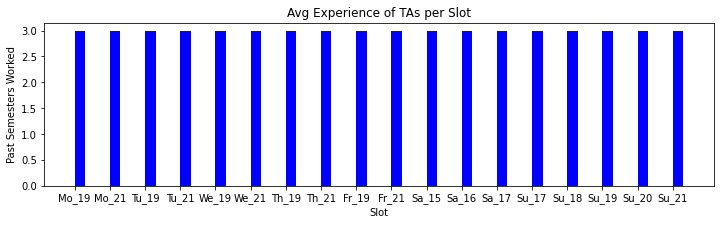

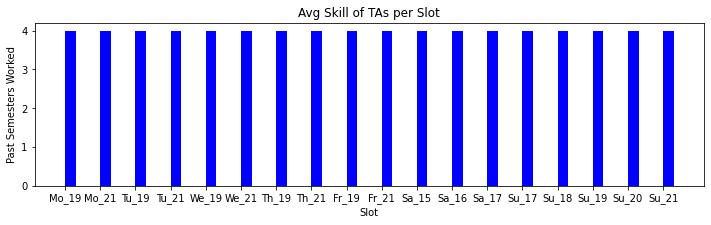

Average Happiness:  97.40740740740742

Availability to happiness correlation:  0.14183773505991065

Variance of happiness:  0.0037317620650954026

Min happy outlier students:  []

Max happy outlier students:  []

Students who got 1's:  []

Students without shifts:  []

Students who got wrong slot type:  ['Ben Schiffer', 'Somya Arora', 'Nathan Alam', 'Avi Bendory', 'Lily Zhang', 'Michelle Woo', 'Nala Sharadjaya', 'Catherine Yu']



In [30]:
custom_schedule = results(weight_dict_custom, csv_file, slotdict)

In [12]:
custom_schedule.print_sched()

Mo_19 : 
['Aditya Kohli', 'Akash Pattnaik', 'Annie Zhou', 'Ariel Rakovitsky', 'HJ Suh', 'Khyati Agrawal', 'Kyle Johnson', 'Yashodhar Govil']
Mo_21 : 
['Ariel Rakovitsky', 'Ben Schiffer', 'Cathleen Kong', 'HJ Suh', 'Sandun Bambarandage', 'Ze Xin Koh']
Tu_19 : 
['Bobby Morck', 'Caroline di Vittorio', 'Sahan Paliskara', 'Uri Schwartz', 'Urvashi Uberoy']
Tu_21 : 
['Alan Ding', 'Bobby Morck', 'Justin Chang', 'Sahan Paliskara', 'Shaurya Garg']
We_19 : 
['Arjun Devraj', 'Avi Bendory', 'Kawin Tiyawattanaroj', 'Michelle Woo', 'Tajreen Ahmed']
We_21 : 
['Arjun Devraj', 'Caroline di Vittorio', 'Charlie Smith', 'Jason Xu', 'Kawin Tiyawattanaroj']
Th_19 : 
['Caio Costa', 'Catherine Yu', 'Khyati Agrawal', 'Tajreen Ahmed', 'Urvashi Uberoy']
Th_21 : 
['Charlie Smith', 'Jason Xu', 'Nala Sharadjaya', 'Niranjan Shankar']
Fr_19 : 
['Annie Zhou', 'Connie Miao', 'Donovan Coronado', 'Somya Arora']
Fr_21 : 
['Lily Zhang', 'Nathan Alam', 'Ryan Golant', 'Somya Arora']
Sa_15 : 
['Anu Vellore', 'Caio Costa', 'Ezr